Task 1

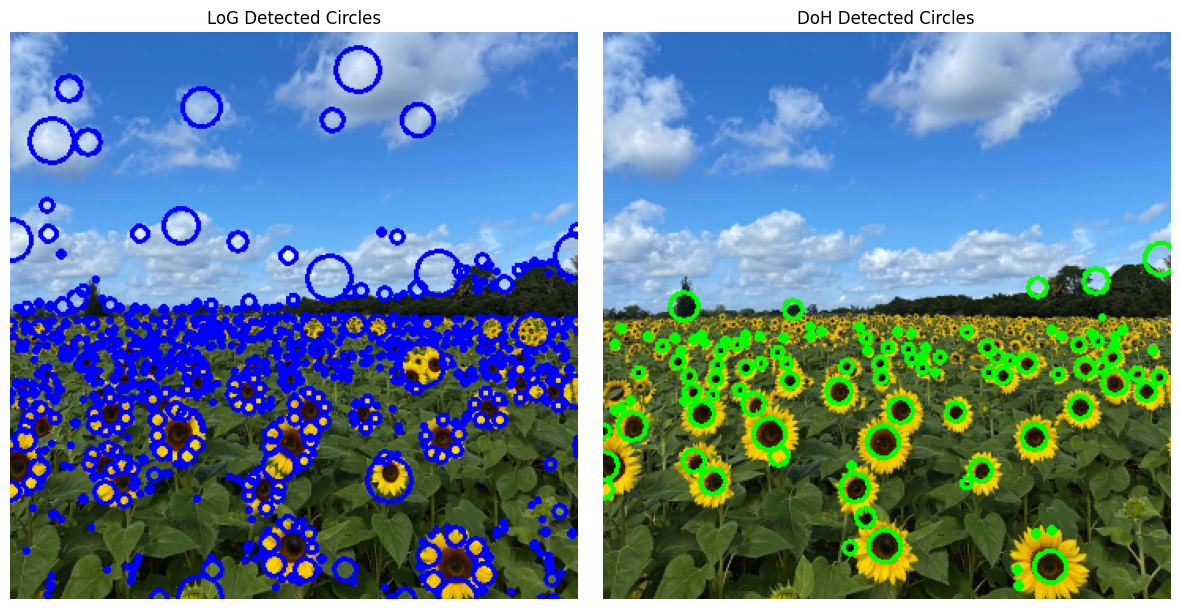

Largest circle using LoG: Center=(153.00, 271.00), Radius=14.14
Largest circle using DoH: Center=(255.00, 105.00), Radius=10.00


In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_doh

# Load the sunflower field image
im = cv.imread('Img/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

# Convert image to grayscale
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Detect blobs using Laplacian of Gaussian (LoG) method
blobs_log = blob_log(gray,min_sigma=1, max_sigma=10, num_sigma=20, threshold=0.1)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)  # Convert sigma to radius

# Detect blobs using Determinant of Hessian (DoH) method
blobs_doh = blob_doh(gray, min_sigma=1, max_sigma=10, num_sigma=20, threshold=0.01)

# Draw the detected circles on the image for LoG
im_log = im.copy()
for blob in blobs_log:
    y, x, r = blob
    cv.circle(im_log, (int(x), int(y)), int(r), (255, 0, 0), 2)

# Draw the detected circles on the image for DoH
im_doh = im.copy()
for blob in blobs_doh:
    y, x, r = blob
    cv.circle(im_doh, (int(x), int(y)), int(r), (0, 255, 0), 2)

# Display the images with detected circles
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv.cvtColor(im_log, cv.COLOR_BGR2RGB))
axes[0].set_title('LoG Detected Circles')
axes[0].axis('off')

axes[1].imshow(cv.cvtColor(im_doh, cv.COLOR_BGR2RGB))
axes[1].set_title('DoH Detected Circles')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Find the largest circle for LoG
if len(blobs_log) > 0:
    largest_blob_log = max(blobs_log, key=lambda b: b[2])
    x_largest_log, y_largest_log, radius_largest_log = largest_blob_log
    print(f"Largest circle using LoG: Center=({x_largest_log:.2f}, {y_largest_log:.2f}), Radius={radius_largest_log:.2f}")
else:
    print("No circles detected using LoG.")

# Find the largest circle for DoH
if len(blobs_doh) > 0:
    largest_blob_doh = max(blobs_doh, key=lambda b: b[2])
    x_largest_doh, y_largest_doh, radius_largest_doh = largest_blob_doh
    print(f"Largest circle using DoH: Center=({x_largest_doh:.2f}, {y_largest_doh:.2f}), Radius={radius_largest_doh:.2f}")
else:
    print("No circles detected using DoH.")


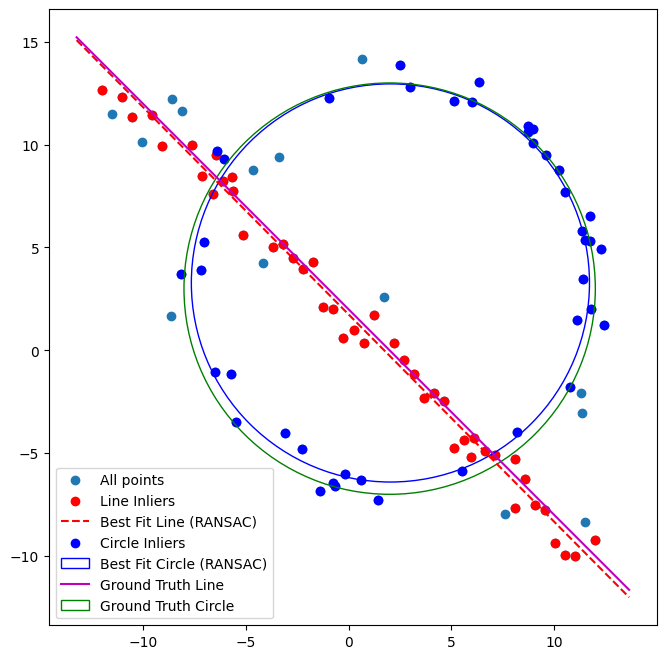

Best Fit Line: Normal=[-0.71003654 -0.70416484], Point on Line=[ 6.6122449  -4.91742667]
Best Fit Circle: Center=[2.0370331  3.27607264], Radius=9.679013715560805


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate noisy points for a line and a circle (as provided)
N = 100
half_n = N // 2

# Circle parameters (Ground truth)
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Line parameters (Ground truth)
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Combine points
X = np.vstack((X_circ, X_line))

# Function to fit a line using RANSAC
def fit_line_ransac(X, threshold=1.0, iterations=100):
    best_inliers = []
    best_line = None
    for i in range(iterations):
        # Randomly select 2 points
        idx = np.random.choice(len(X), 2, replace=False)
        p1, p2 = X[idx]

        # Calculate the normal vector (a, b) to the line
        a, b = p2 - p1
        normal = np.array([-b, a]) / np.linalg.norm([a, b])

        # Calculate distance of all points to the line
        distances = np.abs((X - p1) @ normal)

        # Select inliers
        inliers = X[distances < threshold]
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_line = normal, p1

    return best_line, best_inliers

# Function to fit a circle using RANSAC
def fit_circle_ransac(X, threshold=1.0, iterations=100):
    best_inliers = []
    best_circle = None
    for i in range(iterations):
        # Randomly select 3 points
        idx = np.random.choice(len(X), 3, replace=False)
        p1, p2, p3 = X[idx]

        # Calculate the circle center and radius from the 3 points
        A = 2 * (p2 - p1)
        B = 2 * (p3 - p1)
        C = np.dot(p2, p2) - np.dot(p1, p1)
        D = np.dot(p3, p3) - np.dot(p1, p1)
        center = np.linalg.solve(np.array([A, B]), np.array([C, D]))
        radius = np.linalg.norm(center - p1)

        # Calculate distances from all points to the circle
        distances = np.abs(np.linalg.norm(X - center, axis=1) - radius)

        # Select inliers
        inliers = X[distances < threshold]
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = center, radius

    return best_circle, best_inliers

# Fit the line using RANSAC
best_line, line_inliers = fit_line_ransac(X)

# Remove line inliers and fit a circle using RANSAC
remaining_points = np.array([p for p in X if p not in line_inliers])
best_circle, circle_inliers = fit_circle_ransac(remaining_points)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all points
ax.scatter(X[:, 0], X[:, 1], label='All points')

# Plot line inliers
ax.scatter(line_inliers[:, 0], line_inliers[:, 1], color='r', label='Line Inliers')

# Plot the best fit line
x_vals = np.array(ax.get_xlim())
y_vals = -(best_line[0][0] / best_line[0][1]) * (x_vals - best_line[1][0]) + best_line[1][1]
ax.plot(x_vals, y_vals, 'r--', label='Best Fit Line (RANSAC)')

# Plot circle inliers
ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], color='b', label='Circle Inliers')

# Plot the best fit circle
circle = plt.Circle(best_circle[0], best_circle[1], color='b', fill=False, label='Best Fit Circle (RANSAC)')
ax.add_patch(circle)

# Plot the ground truth line
y_gt_vals = m * x_vals + b
ax.plot(x_vals, y_gt_vals, 'm-', label='Ground Truth Line')

# Plot the ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)

# Set aspect ratio and display the legend
ax.set_aspect('equal')
ax.legend()
plt.show()

# Print results
print(f"Best Fit Line: Normal={best_line[0]}, Point on Line={best_line[1]}")
print(f"Best Fit Circle: Center={best_circle[0]}, Radius={best_circle[1]}")


Click on four points on the architectural image to select the region for the flag.


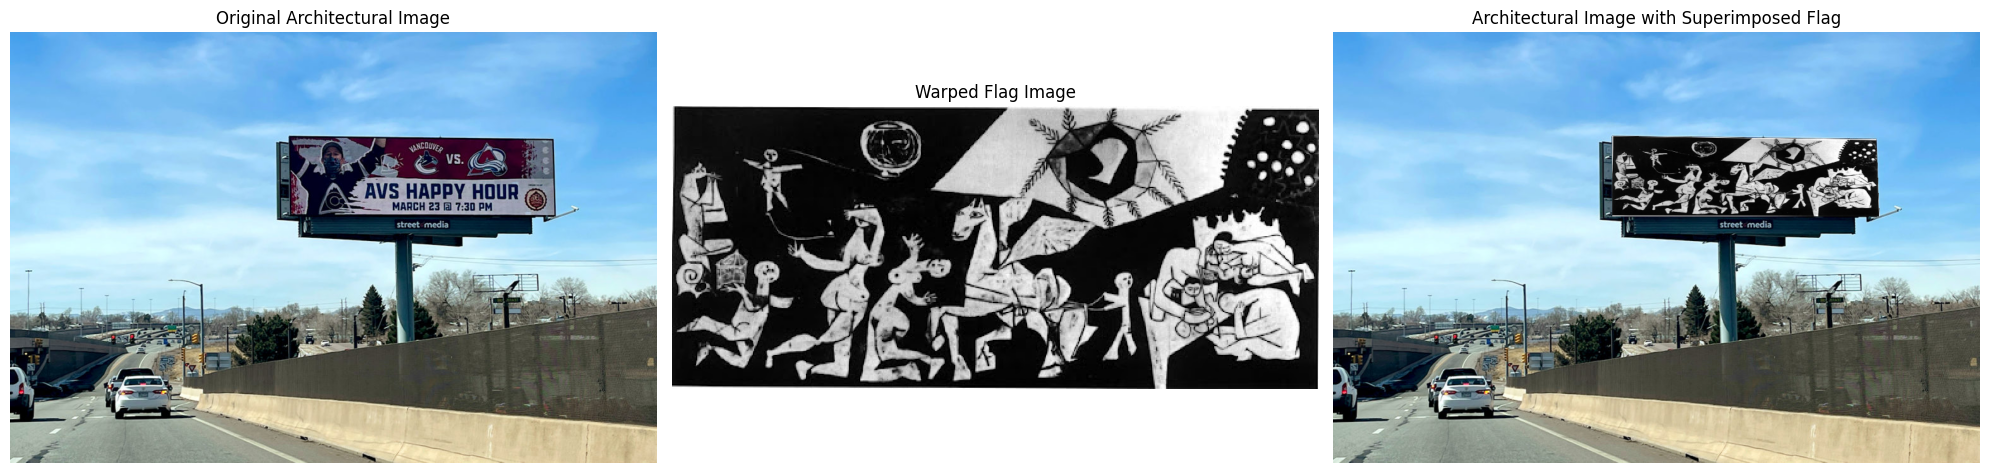

In [14]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the architectural image and the flag image
architectural_img = cv.imread(r'Img\build1.jpg')  # Replace with your architectural image path
flag_img = cv.imread(r'Img\build1stch.jpg')  # Replace with the flag image path

if architectural_img is None or flag_img is None:
    print("Error: Could not load images. Please check the file paths.")
    exit()

# Initialize list to store points clicked by the user
points_architectural = []

# Mouse click event callback function
def select_points(event, x, y, flags, param):
    global points_architectural
    if event == cv.EVENT_LBUTTONDOWN:
        points_architectural.append([x, y])
        cv.circle(architectural_img_display, (x, y), 5, (0, 0, 255), -1)
        cv.imshow("Select 4 Points", architectural_img_display)

# Create a copy for display purposes
architectural_img_display = architectural_img.copy()

# Set up window and mouse callback
cv.namedWindow("Select 4 Points", cv.WINDOW_AUTOSIZE)
cv.setMouseCallback("Select 4 Points", select_points)

# Display the image until 4 points are selected
print("Click on four points on the architectural image to select the region for the flag.")
while len(points_architectural) < 4:
    cv.imshow("Select 4 Points", architectural_img_display)
    if cv.waitKey(10) & 0xFF == 27:  # Press 'Esc' key to exit if needed
        print("User canceled point selection.")
        cv.destroyAllWindows()
        exit()

cv.destroyAllWindows()

# Convert points to NumPy array of type float32
points_architectural = np.array(points_architectural, dtype='float32')

# Get the dimensions of the flag image
height, width, _ = flag_img.shape

# Define the four corners of the flag image
points_flag = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')

# Compute the homography matrix
homography_matrix, _ = cv.findHomography(points_flag, points_architectural)

# Warp the flag image to fit the selected region in the architectural image
warped_flag = cv.warpPerspective(flag_img, homography_matrix, (architectural_img.shape[1], architectural_img.shape[0]))

# Create a mask from the warped flag image
mask = np.zeros_like(architectural_img, dtype=np.uint8)
cv.fillConvexPoly(mask, points_architectural.astype(int), (255, 255, 255))

# Blend the warped flag image with reduced opacity to make it look more natural
alpha = 1  # Opacity level for blending
blended_warped_flag = cv.addWeighted(warped_flag, alpha, architectural_img, 1 - alpha, 0)

# Combine the blended flag with the architectural image
blended_img = cv.bitwise_and(architectural_img, cv.bitwise_not(mask)) + cv.bitwise_and(blended_warped_flag, mask)

# Display the original, warped, and blended images side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Original architectural image
axes[0].imshow(cv.cvtColor(architectural_img, cv.COLOR_BGR2RGB))
axes[0].set_title('Original Architectural Image')
axes[0].axis('off')

# Warped flag image
axes[1].imshow(cv.cvtColor(flag_img, cv.COLOR_BGR2RGB))
axes[1].set_title('Warped Flag Image')
axes[1].axis('off')

# Blended result
axes[2].imshow(cv.cvtColor(blended_img, cv.COLOR_BGR2RGB))
axes[2].set_title('Architectural Image with Superimposed Flag')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Click on four points on the architectural image to select the region for the flag.


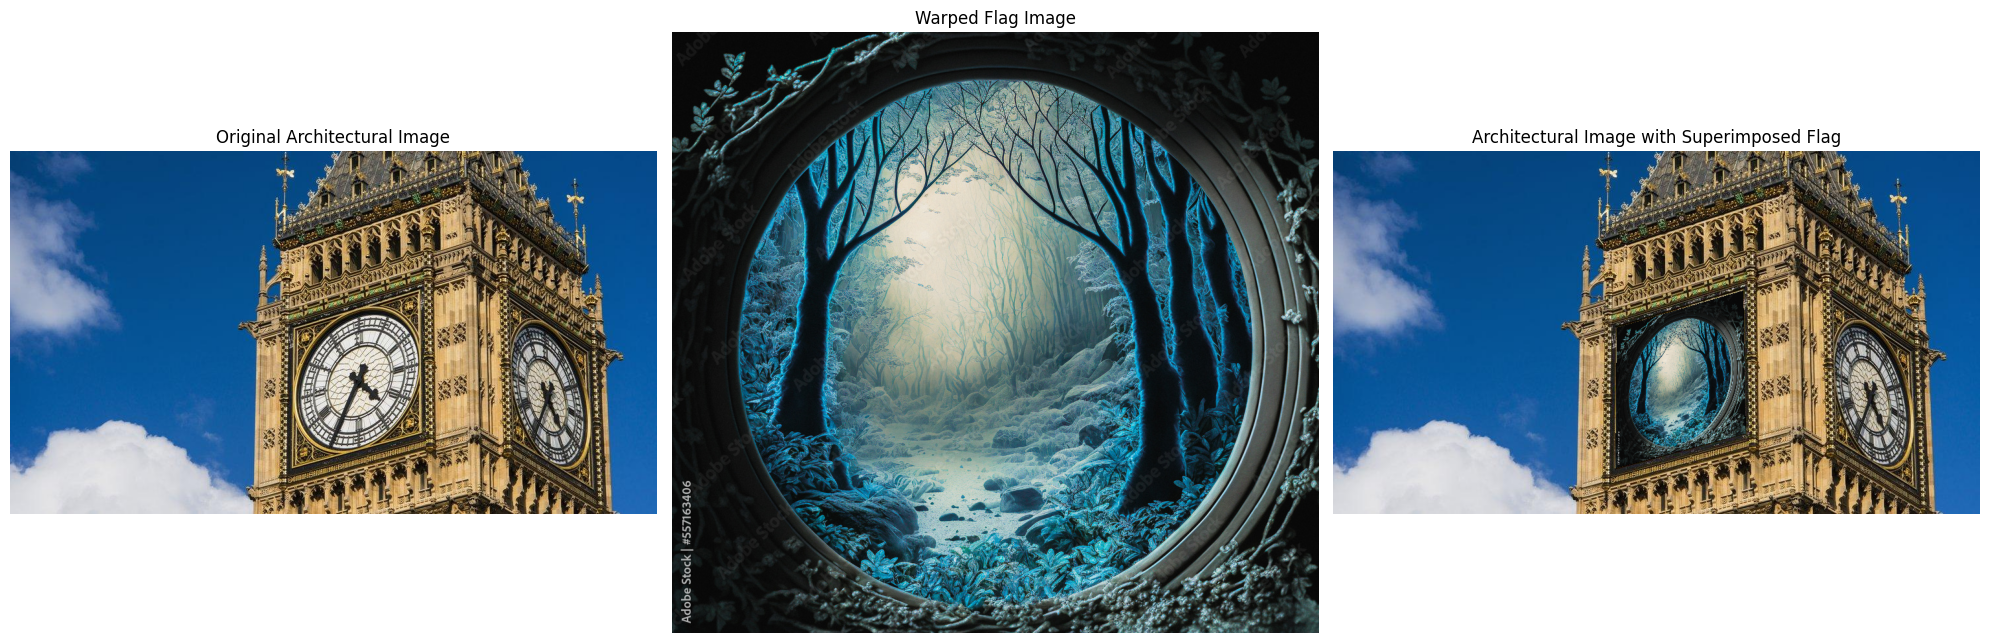

In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the architectural image and the flag image
architectural_img = cv.imread(r'Img\buld2.jpg')  # Replace with your architectural image path
flag_img = cv.imread(r'Img\buld2stich.jpg')  # Replace with the flag image path

if architectural_img is None or flag_img is None:
    print("Error: Could not load images. Please check the file paths.")
    exit()

# Initialize list to store points clicked by the user
points_architectural = []

# Mouse click event callback function
def select_points(event, x, y, flags, param):
    global points_architectural
    if event == cv.EVENT_LBUTTONDOWN:
        points_architectural.append([x, y])
        cv.circle(architectural_img_display, (x, y), 5, (0, 0, 255), -1)
        cv.imshow("Select 4 Points", architectural_img_display)

# Create a copy for display purposes
architectural_img_display = architectural_img.copy()

# Set up window and mouse callback
cv.namedWindow("Select 4 Points", cv.WINDOW_AUTOSIZE)
cv.setMouseCallback("Select 4 Points", select_points)

# Display the image until 4 points are selected
print("Click on four points on the architectural image to select the region for the flag.")
while len(points_architectural) < 4:
    cv.imshow("Select 4 Points", architectural_img_display)
    if cv.waitKey(10) & 0xFF == 27:  # Press 'Esc' key to exit if needed
        print("User canceled point selection.")
        cv.destroyAllWindows()
        exit()

cv.destroyAllWindows()

# Convert points to NumPy array of type float32
points_architectural = np.array(points_architectural, dtype='float32')

# Get the dimensions of the flag image
height, width, _ = flag_img.shape

# Define the four corners of the flag image
points_flag = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')

# Compute the homography matrix
homography_matrix, _ = cv.findHomography(points_flag, points_architectural)

# Warp the flag image to fit the selected region in the architectural image
warped_flag = cv.warpPerspective(flag_img, homography_matrix, (architectural_img.shape[1], architectural_img.shape[0]))

# Create a mask from the warped flag image
mask = np.zeros_like(architectural_img, dtype=np.uint8)
cv.fillConvexPoly(mask, points_architectural.astype(int), (255, 255, 255))

# Blend the warped flag image with reduced opacity to make it look more natural
alpha = 1  # Opacity level for blending
blended_warped_flag = cv.addWeighted(warped_flag, alpha, architectural_img, 1 - alpha, 0)

# Combine the blended flag with the architectural image
blended_img = cv.bitwise_and(architectural_img, cv.bitwise_not(mask)) + cv.bitwise_and(blended_warped_flag, mask)

# Display the original, warped, and blended images side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Original architectural image
axes[0].imshow(cv.cvtColor(architectural_img, cv.COLOR_BGR2RGB))
axes[0].set_title('Original Architectural Image')
axes[0].axis('off')

# Warped flag image
axes[1].imshow(cv.cvtColor(flag_img, cv.COLOR_BGR2RGB))
axes[1].set_title('Warped Flag Image')
axes[1].axis('off')

# Blended result
axes[2].imshow(cv.cvtColor(blended_img, cv.COLOR_BGR2RGB))
axes[2].set_title('Architectural Image with Superimposed Flag')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Click on four points on the architectural image to select the region for the flag.


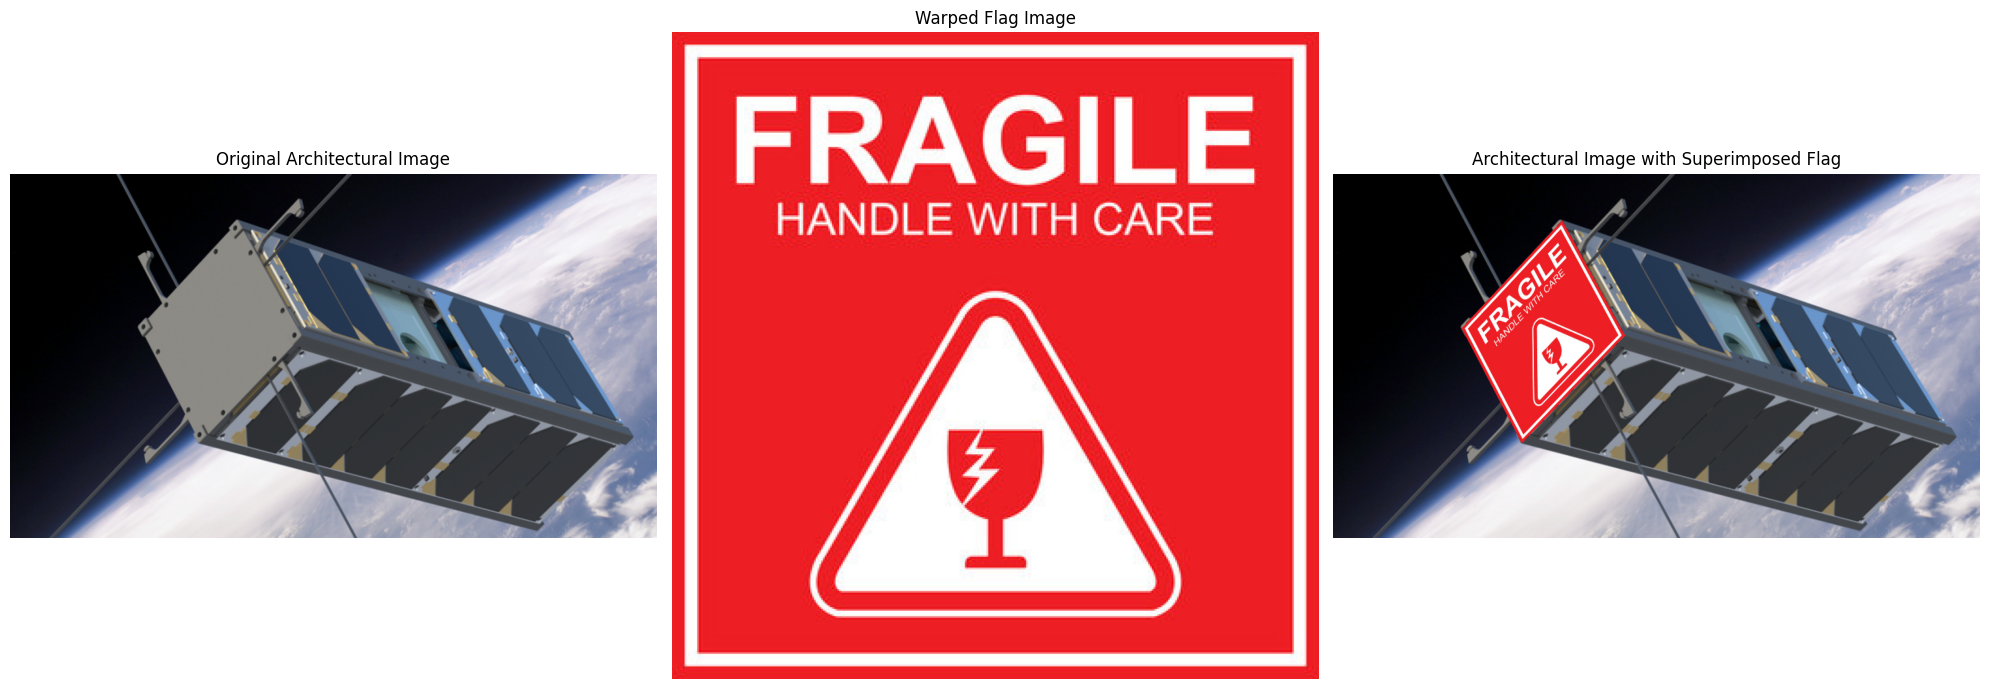

In [16]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the architectural image and the flag image
architectural_img = cv.imread(r'Img\buld3.png')  # Replace with your architectural image path
flag_img = cv.imread(r'Img\buld3stch.jpg')  # Replace with the flag image path

if architectural_img is None or flag_img is None:
    print("Error: Could not load images. Please check the file paths.")
    exit()

# Initialize list to store points clicked by the user
points_architectural = []

# Mouse click event callback function
def select_points(event, x, y, flags, param):
    global points_architectural
    if event == cv.EVENT_LBUTTONDOWN:
        points_architectural.append([x, y])
        cv.circle(architectural_img_display, (x, y), 5, (0, 0, 255), -1)
        cv.imshow("Select 4 Points", architectural_img_display)

# Create a copy for display purposes
architectural_img_display = architectural_img.copy()

# Set up window and mouse callback
cv.namedWindow("Select 4 Points", cv.WINDOW_AUTOSIZE)
cv.setMouseCallback("Select 4 Points", select_points)

# Display the image until 4 points are selected
print("Click on four points on the architectural image to select the region for the flag.")
while len(points_architectural) < 4:
    cv.imshow("Select 4 Points", architectural_img_display)
    if cv.waitKey(10) & 0xFF == 27:  # Press 'Esc' key to exit if needed
        print("User canceled point selection.")
        cv.destroyAllWindows()
        exit()

cv.destroyAllWindows()

# Convert points to NumPy array of type float32
points_architectural = np.array(points_architectural, dtype='float32')

# Get the dimensions of the flag image
height, width, _ = flag_img.shape

# Define the four corners of the flag image
points_flag = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')

# Compute the homography matrix
homography_matrix, _ = cv.findHomography(points_flag, points_architectural)

# Warp the flag image to fit the selected region in the architectural image
warped_flag = cv.warpPerspective(flag_img, homography_matrix, (architectural_img.shape[1], architectural_img.shape[0]))

# Create a mask from the warped flag image
mask = np.zeros_like(architectural_img, dtype=np.uint8)
cv.fillConvexPoly(mask, points_architectural.astype(int), (255, 255, 255))

# Blend the warped flag image with reduced opacity to make it look more natural
alpha = 1 # Opacity level for blending
blended_warped_flag = cv.addWeighted(warped_flag, alpha, architectural_img, 1 - alpha, 0)

# Combine the blended flag with the architectural image
blended_img = cv.bitwise_and(architectural_img, cv.bitwise_not(mask)) + cv.bitwise_and(blended_warped_flag, mask)

# Display the original, warped, and blended images side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Original architectural image
axes[0].imshow(cv.cvtColor(architectural_img, cv.COLOR_BGR2RGB))
axes[0].set_title('Original Architectural Image')
axes[0].axis('off')

# Warped flag image
axes[1].imshow(cv.cvtColor(flag_img, cv.COLOR_BGR2RGB))
axes[1].set_title('Warped Flag Image')
axes[1].axis('off')

# Blended result
axes[2].imshow(cv.cvtColor(blended_img, cv.COLOR_BGR2RGB))
axes[2].set_title('Architectural Image with Superimposed Flag')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Click on four points on the architectural image to select the region for the flag.


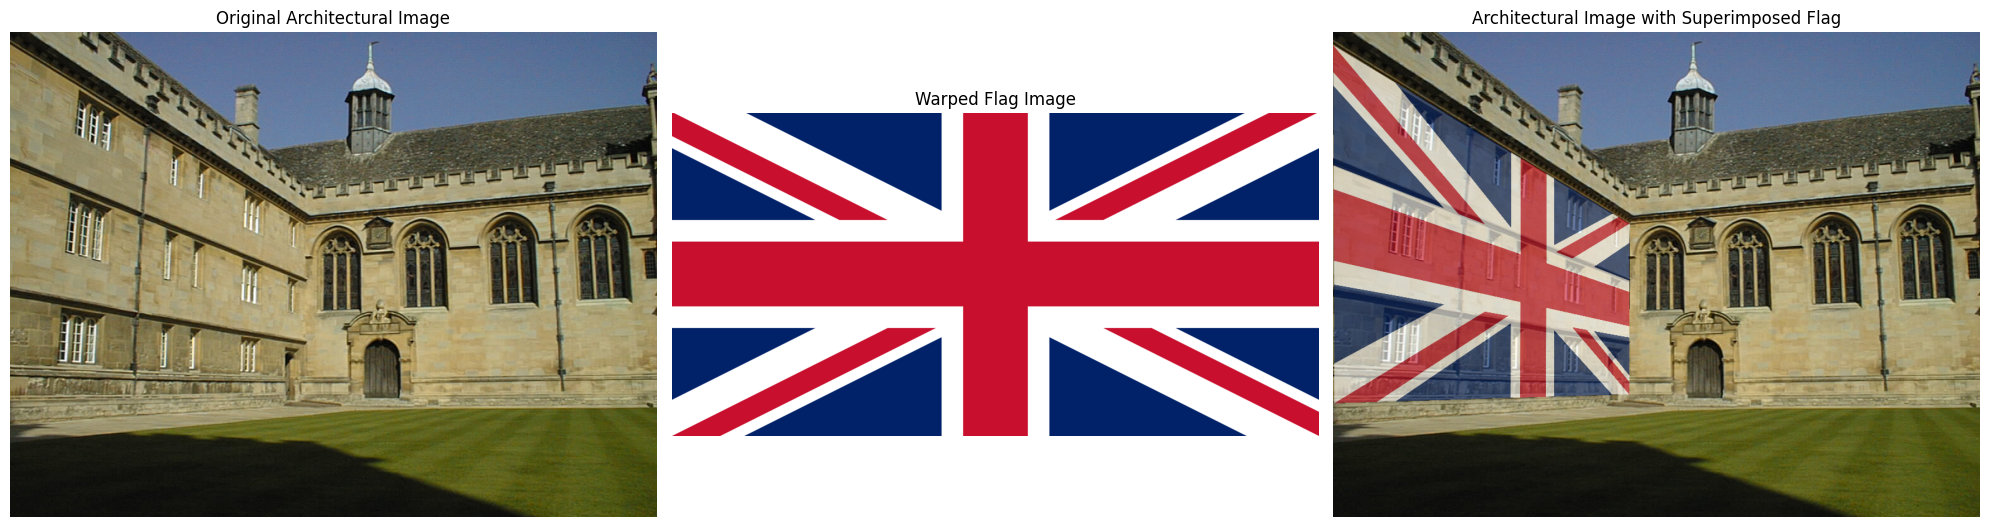

In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the architectural image and the flag image
architectural_img = cv.imread(r'Img\005.jpg')  # Replace with your architectural image path
flag_img = cv.imread(r'Img\flag.png')  # Replace with the flag image path

if architectural_img is None or flag_img is None:
    print("Error: Could not load images. Please check the file paths.")
    exit()

# Initialize list to store points clicked by the user
points_architectural = []

# Mouse click event callback function
def select_points(event, x, y, flags, param):
    global points_architectural
    if event == cv.EVENT_LBUTTONDOWN:
        points_architectural.append([x, y])
        cv.circle(architectural_img_display, (x, y), 5, (0, 0, 255), -1)
        cv.imshow("Select 4 Points", architectural_img_display)

# Create a copy for display purposes
architectural_img_display = architectural_img.copy()

# Set up window and mouse callback
cv.namedWindow("Select 4 Points", cv.WINDOW_AUTOSIZE)
cv.setMouseCallback("Select 4 Points", select_points)

# Display the image until 4 points are selected
print("Click on four points on the architectural image to select the region for the flag.")
while len(points_architectural) < 4:
    cv.imshow("Select 4 Points", architectural_img_display)
    if cv.waitKey(10) & 0xFF == 27:  # Press 'Esc' key to exit if needed
        print("User canceled point selection.")
        cv.destroyAllWindows()
        exit()

cv.destroyAllWindows()

# Convert points to NumPy array of type float32
points_architectural = np.array(points_architectural, dtype='float32')

# Get the dimensions of the flag image
height, width, _ = flag_img.shape

# Define the four corners of the flag image
points_flag = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')

# Compute the homography matrix
homography_matrix, _ = cv.findHomography(points_flag, points_architectural)

# Warp the flag image to fit the selected region in the architectural image
warped_flag = cv.warpPerspective(flag_img, homography_matrix, (architectural_img.shape[1], architectural_img.shape[0]))

# Create a mask from the warped flag image
mask = np.zeros_like(architectural_img, dtype=np.uint8)
cv.fillConvexPoly(mask, points_architectural.astype(int), (255, 255, 255))

# Blend the warped flag image with reduced opacity to make it look more natural
alpha = 0.6  # Opacity level for blending
blended_warped_flag = cv.addWeighted(warped_flag, alpha, architectural_img, 1 - alpha, 0)

# Combine the blended flag with the architectural image
blended_img = cv.bitwise_and(architectural_img, cv.bitwise_not(mask)) + cv.bitwise_and(blended_warped_flag, mask)

# Display the original, warped, and blended images side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Original architectural image
axes[0].imshow(cv.cvtColor(architectural_img, cv.COLOR_BGR2RGB))
axes[0].set_title('Original Architectural Image')
axes[0].axis('off')

# Warped flag image
axes[1].imshow(cv.cvtColor(flag_img, cv.COLOR_BGR2RGB))
axes[1].set_title('Warped Flag Image')
axes[1].axis('off')

# Blended result
axes[2].imshow(cv.cvtColor(blended_img, cv.COLOR_BGR2RGB))
axes[2].set_title('Architectural Image with Superimposed Flag')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Task 4

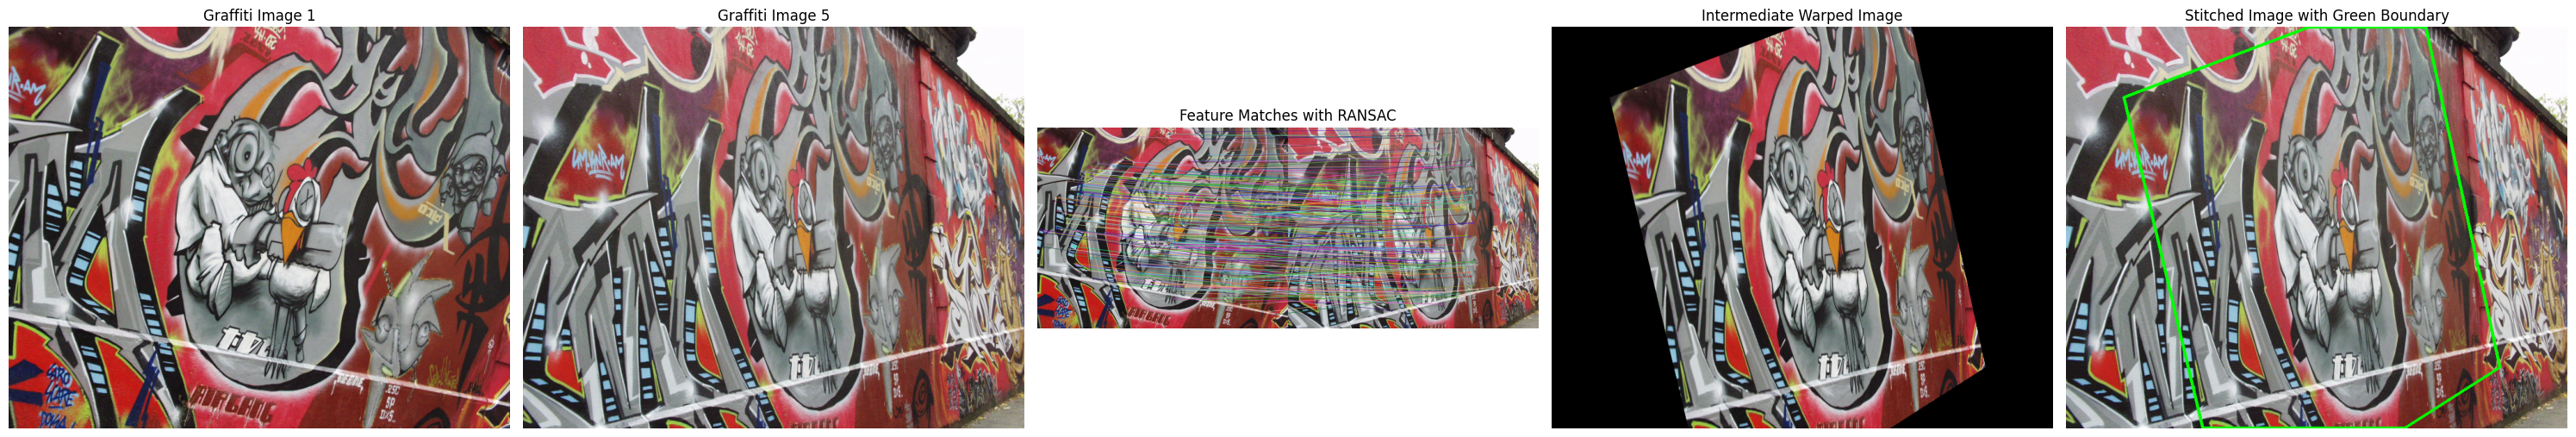

Computed Homography Matrix:
 [[ 7.07093202e-01  2.75632974e-01  9.23409618e+01]
 [-2.36354357e-01  1.14081710e+00  1.12674304e+02]
 [ 2.18363476e-04  4.76726736e-05  1.00000000e+00]]
Actual Homography Matrix from Dataset:
 [[ 7.6285898e-01 -2.9922929e-01  2.2567123e+02]
 [ 3.3443473e-01  1.0143901e+00 -7.6999973e+01]
 [ 3.4663091e-04 -1.4364524e-05  1.0000000e+00]]
Error between Computed and Actual Homography:
 231.84901767445382


In [85]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random

# # Load the images
# img1 = cv.imread(r'Img\test1.jpg')  # Replace with the first graffiti image path
# img5 = cv.imread(r'Img\test2.jpg')  # Replace with the second graffiti image path

img1 = cv.imread(r'Img\graf\graf\img3.ppm',cv.COLOR_RGB2GRAY)  # Replace with the first graffiti image path
img5 = cv.imread(r'Img\graf\graf\img5.ppm',cv.COLOR_RGB2GRAY)  # Replace with the second graffiti image path

if img1 is None or img5 is None:
    print("Error: Could not load images. Please check the file paths.")
    exit()

# Part (a) - Compute and match SIFT features between the two images
sift = cv.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

# Match features using FLANN-based matcher
flann_index_kdtree = 1
index_params = dict(algorithm=flann_index_kdtree, trees=5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors5, k=2)

# Apply Lowe's ratio test to filter good matches
confidence_level = 0.85  # Lowered confidence level for initial detection
good_matches = []
for m, n in matches:
    if m.distance < confidence_level * n.distance:
        good_matches.append(m)

# Draw the matches
img_matches = cv.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Part (b) - Compute the homography using custom RANSAC
max_inliers = 0
best_homography = None
threshold = 2.0  # Reduced threshold for better inlier selection
iterations = 2000  # Increased number of iterations for better convergence

# Extract matched points
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
dst_pts = np.float32([keypoints5[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

for _ in range(iterations):
    # Randomly select 4 points
    idx = random.sample(range(len(good_matches)), 4)
    src_sample = src_pts[idx]
    dst_sample = dst_pts[idx]

    # Compute homography
    H, _ = cv.findHomography(src_sample, dst_sample, 0)
    if H is None:
        continue

    # Project points using the homography
    projected_pts = cv.perspectiveTransform(src_pts.reshape(-1, 1, 2), H).reshape(-1, 2)

    # Compute the Euclidean distance between projected points and actual points
    distances = np.linalg.norm(dst_pts - projected_pts, axis=1)

    # Count inliers
    inliers = np.sum(distances < threshold)

    # Update best homography if more inliers are found
    if inliers > max_inliers:
        max_inliers = inliers
        best_homography = H

# Draw inliers
if best_homography is not None:
    projected_pts = cv.perspectiveTransform(src_pts.reshape(-1, 1, 2), best_homography).reshape(-1, 2)
    inliers_mask = np.linalg.norm(dst_pts - projected_pts, axis=1) < threshold
    img_ransac_matches = cv.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None,
                                        matchesMask=inliers_mask.astype(int).tolist(), flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
else:
    print("Homography could not be computed with RANSAC.")
    exit()

# Part (c) - Stitch img1 onto img5
if best_homography is not None:
    height, width, _ = img5.shape
    stitched_img = cv.warpPerspective(img1, best_homography, (width, height))


    # Create masks for blending
    mask_stitched = (stitched_img > 0).astype(np.uint8)
    img5_masked = cv.bitwise_and(img5, img5, mask=cv.bitwise_not(mask_stitched[:, :, 0]))

    # Feather blending to reduce visible seams
    overlap_region = (mask_stitched[:, :, 0] & (img5[:, :, 0] > 0)).astype(np.float32)
    alpha = cv.GaussianBlur(overlap_region, (21, 21), 0) / 255.0

    # Weighted blend in overlapping areas
    blended_img = np.uint8(stitched_img * alpha[:, :, None] + img5_masked * (1 - alpha[:, :, None]))

    # Draw a green boundary to identify the stitching area
    green_boundary = (mask_stitched[:, :, 0] > 0).astype(np.uint8)
    contours, _ = cv.findContours(green_boundary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(blended_img, contours, -1, (0, 255, 0), 3)
else:
    print("Homography could not be computed.")
    exit()

# Display the images side by side
fig, axes = plt.subplots(1, 5, figsize=(30, 12))

# Original images
axes[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
axes[0].set_title('Graffiti Image 1')
axes[0].axis('off')

axes[1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
axes[1].set_title('Graffiti Image 5')
axes[1].axis('off')

# Matches
axes[2].imshow(cv.cvtColor(img_ransac_matches, cv.COLOR_BGR2RGB))
axes[2].set_title('Feature Matches with RANSAC')
axes[2].axis('off')

# Intermediate Warped Image
axes[3].imshow(cv.cvtColor(stitched_img, cv.COLOR_BGR2RGB))
axes[3].set_title('Intermediate Warped Image')
axes[3].axis('off')

# Blended/Stitched Image
axes[4].imshow(cv.cvtColor(blended_img, cv.COLOR_BGR2RGB))
axes[4].set_title('Stitched Image with Green Boundary')
axes[4].axis('off')

plt.tight_layout()
plt.show()

# Print the homography matrix from the transformation
print("Computed Homography Matrix:\n", best_homography)

# Load the actual homography matrix from file and compare
actual_homography_path = r'Img\graf\graf\H1to3p'
actual_homography = np.loadtxt(actual_homography_path)
print("Actual Homography Matrix from Dataset:\n", actual_homography)

# Calculate the error between the computed and actual homography
homography_error = np.linalg.norm(actual_homography - best_homography)
print("Error between Computed and Actual Homography:\n", homography_error)
